In [6]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=1Soh3zXLXt2lT7b_3FcWWyeOCC7SnOxK0 )
zip_id = '1bqJc-24Xhaf18ytPxJNo4z25k4EiOWy7'
json_id = '11UiwYdt7XAGcWbbRGaqEOLwkzUlWTOHR'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('flowers_data.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('flowers_data.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()


# DOWNLOAD JSON File
print ("Downloading json file")
myJSON = drive.CreateFile({'id': json_id})
myJSON.GetContentFile('cat_to_name.json')



######### installation##############
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip uninstall -y Pillow
!pip install Pillow==5.3.0

########################################

#############PACKAGE#################
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

Uncompressing zip file
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
############ TODO: Define your transforms for the training and validation sets #################
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
###############FOLDER DIRECTORY########

data_dir = '/content/MODEL/flower_data'
train_dir = '/content/MODEL/flower_data/train'
valid_dir = '/content/MODEL/flower_data/valid'
dirs = {'train': train_dir, 
        'valid': valid_dir}

########### TODO: Load the datasets with ImageFolder##########
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}

########### TODO: Using the image datasets and the trainforms, define the dataloaders###########
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#######LABEL MAPPING#############

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
model = models.vgg19(pretrained=True)

In [0]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [0]:
###########FREEEZE PRETRAINED PARAMETER#########
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.classifier = classifier

In [0]:
#### TODO: Build and train your network ######
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  

In [0]:
# Observe that all parameters are being optimized
from torch import nn, optim
optim = optim.Adam(model.classifier.parameters(), lr=0.001)

# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()


# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optim , step_size=4, gamma=0.1)
# Number of epochs
eps=10

In [16]:
model = model.to(device)

model_ft = train_model(model, criteria, optim, sched, eps)


Epoch 0/9
----------
train Loss: 2.4593 Acc: 0.4757
valid Loss: 1.0232 Acc: 0.7090

Epoch 1/9
----------
train Loss: 1.1337 Acc: 0.6903
valid Loss: 0.7423 Acc: 0.7885

Epoch 2/9
----------
train Loss: 0.9664 Acc: 0.7402
valid Loss: 0.6402 Acc: 0.8264

Epoch 3/9
----------
train Loss: 0.8719 Acc: 0.7604
valid Loss: 0.5469 Acc: 0.8582

Epoch 4/9
----------
train Loss: 0.6112 Acc: 0.8234
valid Loss: 0.4024 Acc: 0.9071

Epoch 5/9
----------
train Loss: 0.5468 Acc: 0.8433
valid Loss: 0.3864 Acc: 0.9108

Epoch 6/9
----------
train Loss: 0.5006 Acc: 0.8600
valid Loss: 0.3667 Acc: 0.9120

Epoch 7/9
----------
train Loss: 0.4668 Acc: 0.8671
valid Loss: 0.3798 Acc: 0.9071

Epoch 8/9
----------
train Loss: 0.4694 Acc: 0.8680
valid Loss: 0.3718 Acc: 0.9132

Epoch 9/9
----------
train Loss: 0.4400 Acc: 0.8779
valid Loss: 0.3669 Acc: 0.9144

Training complete in 45m 36s
Best val Acc: 0.914425


In [0]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device)    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')

In [23]:
model_ft = model.to(device)
model_ft = train_model(model_ft, criteria, optim, sched,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4507 Acc: 0.8716
valid Loss: 0.3649 Acc: 0.9156

Epoch 1/9
----------
train Loss: 0.4539 Acc: 0.8718
valid Loss: 0.3603 Acc: 0.9181

Epoch 2/9
----------
train Loss: 0.4273 Acc: 0.8770
valid Loss: 0.3601 Acc: 0.9181

Epoch 3/9
----------
train Loss: 0.4192 Acc: 0.8785
valid Loss: 0.3599 Acc: 0.9181

Epoch 4/9
----------
train Loss: 0.4512 Acc: 0.8745
valid Loss: 0.3600 Acc: 0.9169

Epoch 5/9
----------
train Loss: 0.4268 Acc: 0.8785
valid Loss: 0.3600 Acc: 0.9193

Epoch 6/9
----------
train Loss: 0.4421 Acc: 0.8730
valid Loss: 0.3600 Acc: 0.9181

Epoch 7/9
----------
train Loss: 0.4533 Acc: 0.8678
valid Loss: 0.3600 Acc: 0.9169

Epoch 8/9
----------
train Loss: 0.4310 Acc: 0.8767
valid Loss: 0.3600 Acc: 0.9193

Epoch 9/9
----------
train Loss: 0.4494 Acc: 0.8709
valid Loss: 0.3600 Acc: 0.9169

Training complete in 45m 37s
Best val Acc: 0.919315


In [0]:
def load_model(checkpoint_path):
#     chpt = torch.load(checkpoint_path)
    chpt = torch.load(checkpoint_path)
    pretrained_model = getattr(models, chpt['arch'])
    if callable(pretrained_model):
        model = pretrained_model(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
#     if chpt['arch'] == 'vgg19':
#         model = models.vgg19(pretrained=True)
#         for param in model.parameters():
#             param.requires_grad = False
    else:
        print("Sorry base architecture is not recognized")
        return
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [31]:
model = load_model('classifier.pth')
# calc_accuracy(model,'test',True)
calc_accuracy(model, input_image_size=224, testset_path=valid_dir)

TypeError: ignored

In [0]:
image_path = (f"/content/MODEL/flower_data/valid/1/image_06749.jpg")
img = Image.open(image_path)
# model=load_checkpoint(img)

In [0]:
if img.size[0] > img.size[1]:
    img.thumbnail((1000000, 256)) #constrain the height to be 256
else:
    img.thumbnail((256, 200000)) #otherwise constrain the width

In [0]:
left_margin = (img.width-224)/2
bottom_margin = (img.height-224)/2
right_margin = left_margin + 224
top_margin = bottom_margin + 224

In [0]:
img = img.crop((left_margin, bottom_margin, right_margin,    
                   top_margin))

In [0]:
img = np.array(img)/255

In [0]:
mean = np.array([0.485, 0.456, 0.406]) #provided mean
std = np.array([0.229, 0.224, 0.225]) #provided std
img = (img - mean)/std

In [0]:
img = img.transpose((2, 0, 1))

In [0]:
################PROCESS IMAGE###############
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

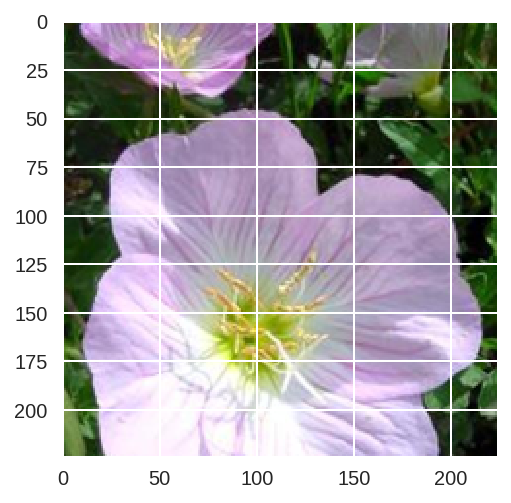

In [0]:
image_path = F'/content/MODEL/flower_data/valid/1/image_06749.jpg'
img = process_image(image_path)
imshow(img)